In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
np.random.seed(1000)

In [33]:
file_path = "S_plasample_cube_40.txt"
datasets = []
current_dataset = []
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith("#Parameters"):
            if current_dataset:
                datasets.append(current_dataset)
                current_dataset = []
            params_str = line[line.index("{")+1:line.index("}")]
            params = dict(param.split('=') for param in params_str.split(';'))
            current_dataset.append(params)
        elif line.startswith("#"):
            continue
        else:
            data = line.strip().split('\t')
            current_dataset.append(data)
if current_dataset:
    datasets.append(current_dataset)
for i, dataset in enumerate(datasets):
    permittivity_values = dataset[0]
    df_data = dataset[1:]
    df = pd.DataFrame(df_data, columns=["Frequency", "Real", "Imaginary"])
    print(f"Dataset {i+1} - Permittivity values:")
    for key, value in permittivity_values.items():
        print(f"{key}: {value}")
    print("Data:")
    print(df)
    print()

Dataset 1 - Permittivity values:
vshift: -21.275
 cc: 40
 bb: 40
 aa: 40
 erpla1: 0.0041269841269841
 erpla: 3.15
 L1: 67
 L2: 32
 L22: 60
 L3: 34.5
 a1: -110.3314
 a2: 110.3314
 b1: -28.048
 b2: 110.3821
 c1: 0
 c2: 11.9761
 d1: -82.55
 d2: 82.55
 e1: 0
 e2: 82.3341
 er1: 2.55
 er11: 2.55
 h1: 14
 h22: 14
 h33: 28.5
 r0: 10.38125
 r00: 13
 r1: 8.001
 r11: 10.5
 r2: 2.09
 r22: 4.5
 r3: 7.653
 r33: 17
 r44: 2.75
 th1: 4.7625
 th11: 4.7625
 th2: 4.7625
 umax: 82.55
 umin1: -87.3125
 umin2: -82.55
 vmax: 87.0966
 vmin: 82.55
 vmin1: -4.7625
 vmin2: 87.0966
 wmax: 138.1125
 wx: 165.1
 wx2: 220.662
 wx_2: 174.625
 wx_21: 220.6628
 wx_22: 165.1
 wy: 82.55
 wy2: 138.43
 wy_2: 91.8591
 wy_21: 138.4301
 wy_22: 82.3341
 wz: 1000
 wz2: 12
 wz_2: 209.55
 wz_21: 14
 wz_22: 204.01
 zshift: 101
 zshift1: 154
Data:
            Frequency                Real          Imaginary
0     1.0000000000000  -0.079316847026348   0.32380053400993
1     1.0010000467300  -0.065709270536900   0.32323741912842
2     

In [34]:
mat = scipy.io.loadmat('data.mat')
out_data = mat['out_data']
df = pd.DataFrame(out_data)
df.columns = ['frequency','permittivity_real','permittivity_imaginary','s11_real','s11_imaginary']
print(df.head(20))

    frequency  permittivity_real  permittivity_imaginary  s11_real   
0       1.199           2.572762                0.064912 -0.003002  \
1       1.199           3.008671                0.073172 -0.003481   
2       1.199           5.928357                0.064775 -0.006756   
3       1.199           4.786311                0.045092 -0.006433   
4       1.199           3.813276                0.054701 -0.005164   
5       1.199           7.646629                0.029632 -0.008666   
6       1.199           5.682113                0.074469 -0.006294   
7       1.199           5.397789                0.018896 -0.007740   
8       1.199           8.337549                0.068678 -0.007830   
9       1.199           3.286712                0.018351 -0.005592   
10      1.199           7.057602                0.036848 -0.008175   
11      1.199           7.029833                0.062562 -0.007415   
12      1.199           4.043567                0.078023 -0.004763   
13      1.199       

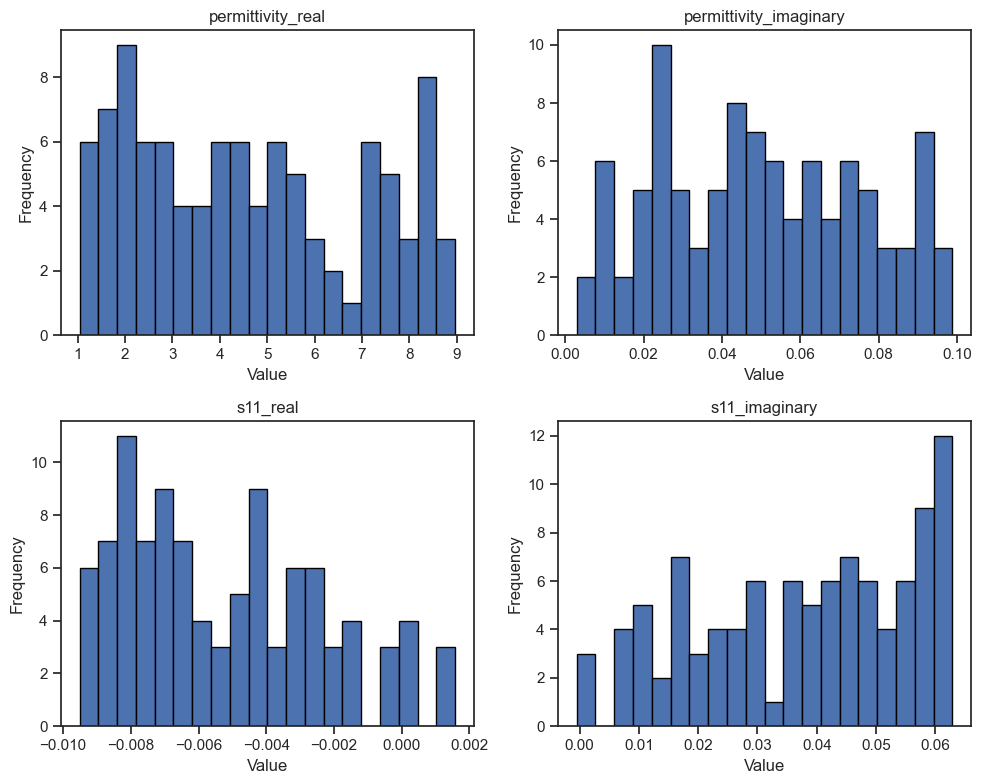

In [35]:
columns = ['permittivity_real', 'permittivity_imaginary', 's11_real', 's11_imaginary']
plt.figure(figsize=(10, 8))
for i, column in enumerate(columns):
    plt.subplot(2, 2, i+1)
    plt.hist(df[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

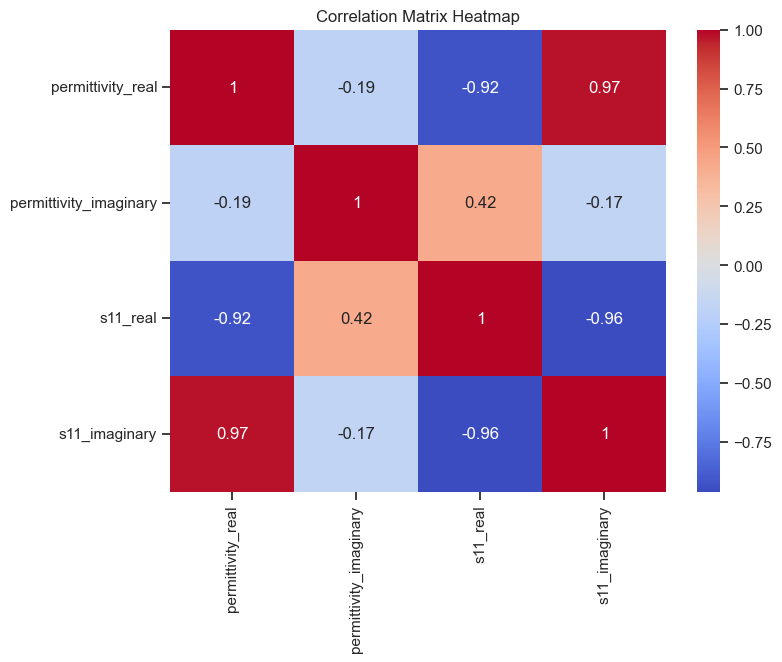

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['permittivity_real','permittivity_imaginary','s11_real','s11_imaginary']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

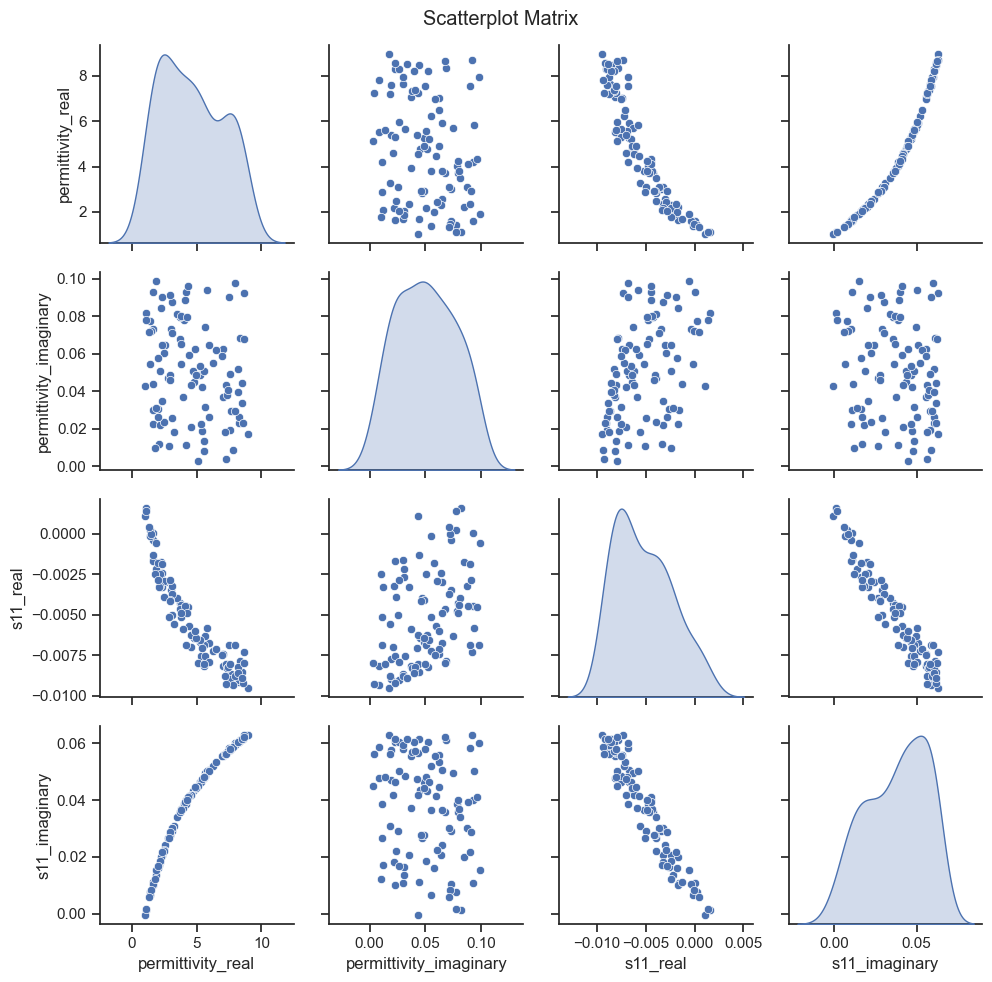

In [37]:
sns.set(style="ticks")
sns.pairplot(df[columns], diag_kind="kde")
plt.suptitle('Scatterplot Matrix')
plt.tight_layout()
plt.show()

In [38]:
X = df[['s11_real', 's11_imaginary']].values
y = df[['permittivity_real']].values

In [39]:
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]
split_point = int(0.80 * len(X))
X_train = X[:split_point]
y_train = y[:split_point]
X_val = X[split_point:]
y_val = y[split_point:]

In [40]:
X_train.shape

(80, 2)

In [41]:
y_train.shape

(80, 1)

In [42]:
X_val.shape

(20, 2)

In [43]:
y_val.shape

(20, 1)

In [44]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(y.shape[1], activation='linear')
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=[tf.losses.MeanAbsoluteError()], metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanSquaredError()])

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               384       
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 11265 (44.00 KB)
Trainable params: 11265 (44.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/500
80/80 [==============================] - 0s 1ms/step - loss: 4.5549 - mean_absolute_error: 4.5549 - mean_squared_error: 26.2339 - val_loss: 4.6420 - val_mean_absolute_error: 4.6420 - val_mean_squared_error: 27.3787
Epoch 2/500
80/80 [==============================] - 0s 585us/step - loss: 4.4288 - mean_absolute_error: 4.4288 - mean_squared_error: 25.0660 - val_loss: 4.4536 - val_mean_absolute_error: 4.4536 - val_mean_squared_error: 25.6345
Epoch 3/500
80/80 [==============================] - 0s 585us/step - loss: 4.1219 - mean_absolute_error: 4.1219 - mean_squared_error: 22.4111 - val_loss: 3.9780 - val_mean_absolute_error: 3.9780 - val_mean_squared_error: 21.5684
Epoch 4/500
80/80 [==============================] - 0s 584us/step - loss: 3.3725 - mean_absolute_error: 3.3725 - mean_squared_error: 16.4496 - val_loss: 2.8946 - val_mean_absolute_error: 2.8946 - val_mean_squared_error: 13.9224
Epoch 5/500
80/80 [==============================] - 0s 583us/step - loss: 2.4923 - me

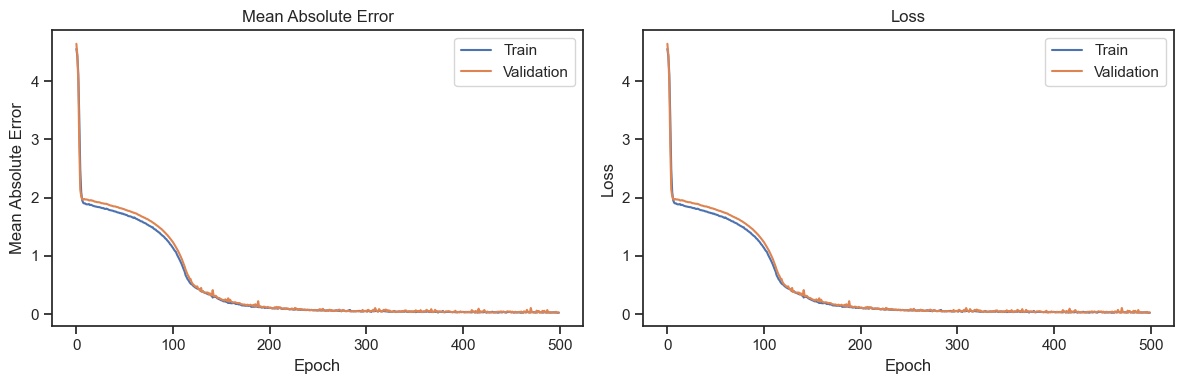

In [46]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 30ms/step


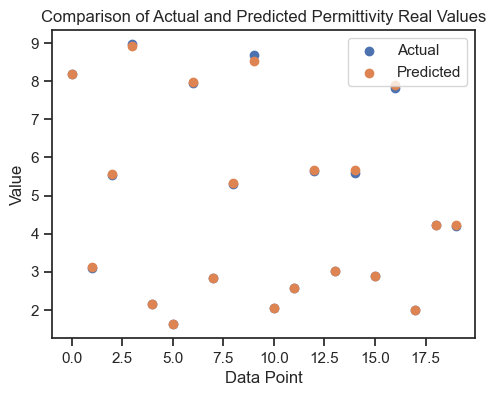

In [47]:
y_pred = model.predict(X_val)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 0], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 0], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()